# **Solution for the Kaggle's Competition "Feedback Prize - Predicting Effective Arguments"**

Solution for the Kaggle competition "Feedback Prize - Predicting Effective Arguments - Rate the effectiveness of argumentative writing elements from students grade 6-12". The goal of this competition is to classify argumentative elements in student writing as "effective", "adequate" or "ineffective" creating a model using data that is representative of the 6th-12th grade population in the United States. The purpose is to provide students enhanced feedback on their argumentative writing with automated guidance using machine learning.

For this competition I will use a Long Short Term Memory network (LSTM) so we can consider all the sequence of data to make the classifications.

**Importing the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


**Loading the training and test datasets**

In [2]:
dataset_test = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/test.csv")
dataset_train = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/train.csv")

**Exploring and analysing the training set (EDA - Exploratory Data Analysis)**

In [3]:
dataset_train.head(5)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


We can see that the training set has no missing values, since all the columns has 36765 values being strings.

In [4]:
dataset_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


The unique values of "discourse_id" (36765) is differente compared to "discourse_text" (36691), indicating that there are duplicate values (assuming that for each discourse id, there is a unique discourse text associated).

In [5]:
dataset_train.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


Here we can see all the duplicate results with also different "discourse_effectiveness" for a same "discourse_text".

In [6]:
duplicadas_geral = dataset_train[dataset_train.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")
duplicadas_geral

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
...,...,...,...,...,...
27033,f6b2d34d9c01,A98E8EFFC8A9,the technology failing,Claim,Adequate
35488,bcdb6e47ede3,AB8EFBD82820,you can help others.,Claim,Ineffective
35493,98510222f9b8,AB8EFBD82820,you can help others.,Claim,Adequate
4788,d068e2c646e8,56C6D97AF40B,you get to see the world,Claim,Adequate


There's a total of 11 duplicated discourse texts with differente "discourse effectiveness".

In [7]:
duplicadas_analise = duplicadas_geral.groupby(["discourse_type", "discourse_text"]).discourse_effectiveness.nunique().to_frame().sort_values(by="discourse_effectiveness", ascending=False)
duplicadas_analise.columns = ["discourse_effectiveness_nonUnique"]
duplicadas_analise = duplicadas_analise[duplicadas_analise.discourse_effectiveness_nonUnique > 1].reset_index(drop=False)  
duplicadas_analise

,discourse_type,discourse_text,discourse_effectiveness_nonUnique
0,Claim,"opinions,",2
1,Claim,"Second, there could be a tie in the electoral ...",2
2,Claim,The Electoral College is unfair,2
3,Lead,"When people ask for advice, they sometimes tal...",2
4,Claim,Big States,2
5,Position,I would want to keep the Electoral College,2
6,Claim,you can help others.,2
7,Claim,"be creative,",2
8,Position,The author suggest that studying Venus is a wo...,2
9,Position,Seeking multiple opinions can help someone mak...,2


In [8]:
duplicadas_geral_analise = duplicadas_geral[duplicadas_geral.discourse_text.isin(duplicadas_analise.discourse_text)] 
duplicadas_geral_analise.head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
20842,34b98386dc46,5729D5AE055C,I would want to keep the Electoral College,Position,Effective
28406,98154af4855d,BACC53ECC1FB,I would want to keep the Electoral College,Position,Adequate
11970,cc0dad1234ec,D8013F49DE51,Opponents say that cell phones are good becaus...,Counterclaim,Adequate
6570,dee3f8aec4fc,7742D58270C9,Opponents say that cell phones are good becaus...,Counterclaim,Ineffective
31753,b318a4e3b80e,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Effective
31757,43848fd5dfb3,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Adequate
35299,608e1d81f4ed,9627B47C10DE,Seeking multiple opinions can help someone mak...,Position,Effective
34383,3312a23a5480,523EBD9ECA47,Seeking multiple opinions can help someone mak...,Position,Adequate


**Visualizing some graphs**

Text(0, 0.5, 'Count')

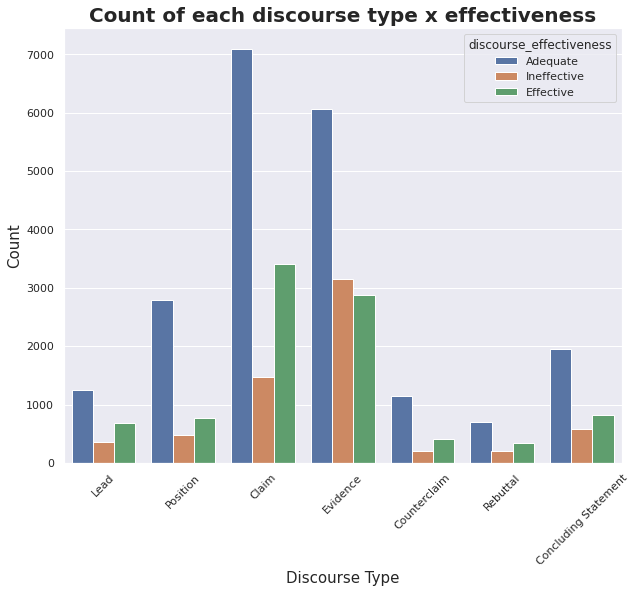

In [9]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações e as notas correspondentes
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", hue="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type x effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

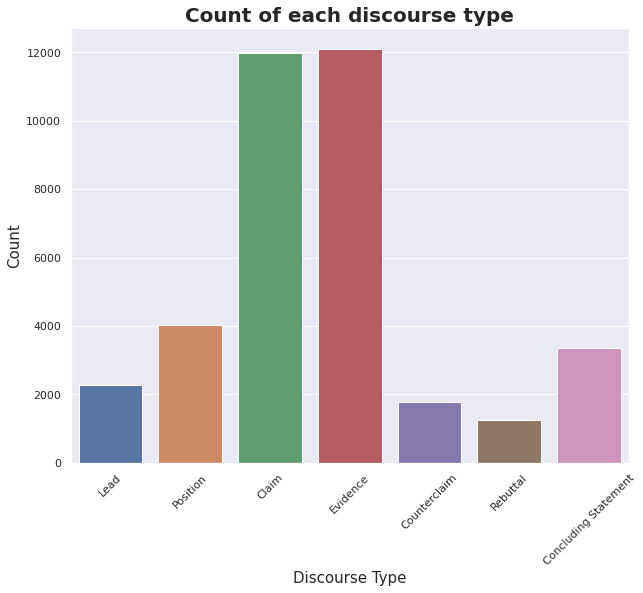

In [10]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

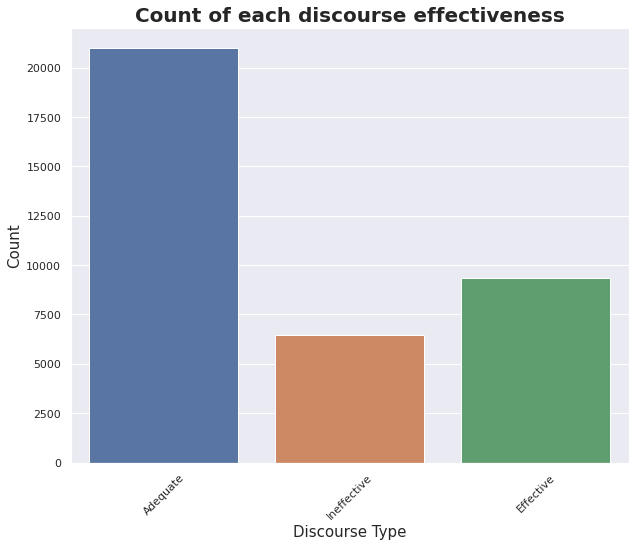

In [11]:
plt.figure(figsize=(10, 8))   # 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

We can see that, on average, each essay has approximately 9 "discourse_text":

In [12]:
discType_essayID = dataset_train.groupby(["essay_id"]).discourse_type.value_counts().to_frame()   # Contagem de "discourse_type" no training set para as "essay_id"
discType_essayID.columns = ["Contagem"]
discType_essayID.reset_index(drop=False, inplace=True)
discType_essayID = discType_essayID.pivot(index="essay_id", columns="discourse_type").Contagem

discType_essayID["Total_Sum"] = discType_essayID.sum(axis=1)  # Cria uma nova coluna com a soma de cada count do discourse type em cada linha
discType_essayID

discourse_type,Claim,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal,Total_Sum
essay_id,,,,,,,,
00066EA9880D,3.0,1.0,NaN,3.0,1.0,1.0,NaN,9.0
000E6DE9E817,5.0,1.0,1.0,3.0,NaN,1.0,1.0,12.0
0016926B079C,7.0,NaN,NaN,3.0,NaN,1.0,NaN,11.0
00203C45FC55,1.0,1.0,3.0,3.0,1.0,1.0,3.0,13.0
0029F4D19C3F,2.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0
...,...,...,...,...,...,...,...,...
FFA381E58FC6,2.0,1.0,NaN,1.0,NaN,1.0,NaN,5.0
FFC43F453EF6,4.0,1.0,3.0,1.0,NaN,1.0,1.0,11.0
FFD97A99CEBA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [13]:
discType_essayID.Total_Sum.mean()

8.772369362920545

Analyzing the words, chars and sentences counts to see the relationship with the quality rating:

In [14]:
dataset_train["discourse_text_numChars"] = dataset_train.discourse_text.apply(lambda x: len(x))
dataset_train["discourse_text_numWords"] = dataset_train.discourse_text.apply(lambda x: len(x.split()))
dataset_train["discourse_text_numSentences"] = dataset_train.discourse_text.apply(lambda x: len(tokenize.sent_tokenize(x, language="english")))

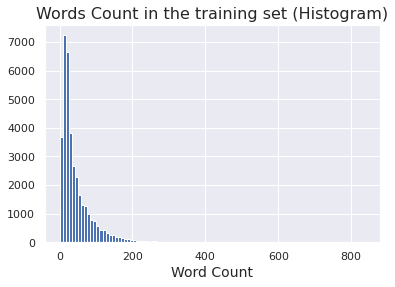

In [15]:
plt.hist(dataset_train["discourse_text_numWords"], bins=100)
plt.title("Words Count in the training set (Histogram)", size = 16)
plt.xlabel("Word Count", size = 14)
plt.show()

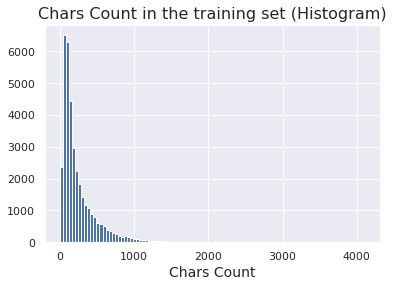

In [16]:
plt.hist(dataset_train["discourse_text_numChars"], bins=100)
plt.title("Chars Count in the training set (Histogram)", size = 16)
plt.xlabel("Chars Count", size = 14)
plt.show()

Text(0.5, 0, 'Word Count')

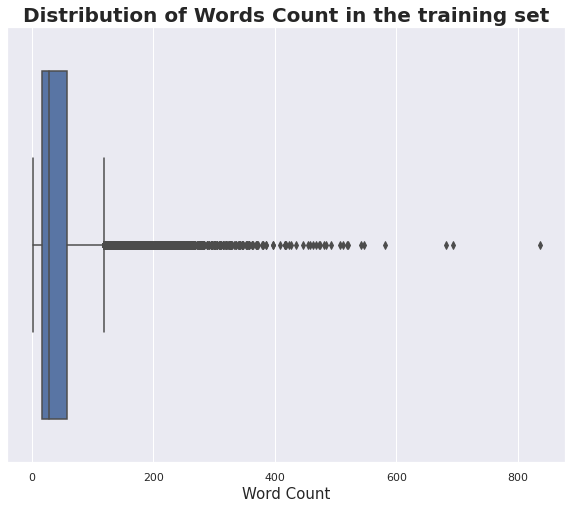

In [17]:
plt.figure(figsize=(10, 8))   
ax = sns.boxplot(x=dataset_train["discourse_text_numWords"])
ax.set_title("Distribution of Words Count in the training set", fontsize=20, weight='bold')
plt.xlabel("Word Count", fontsize=15)

It's possible to see that higher word counts tend to have better quality ratings:

Text(0, 0.5, 'Word Count')

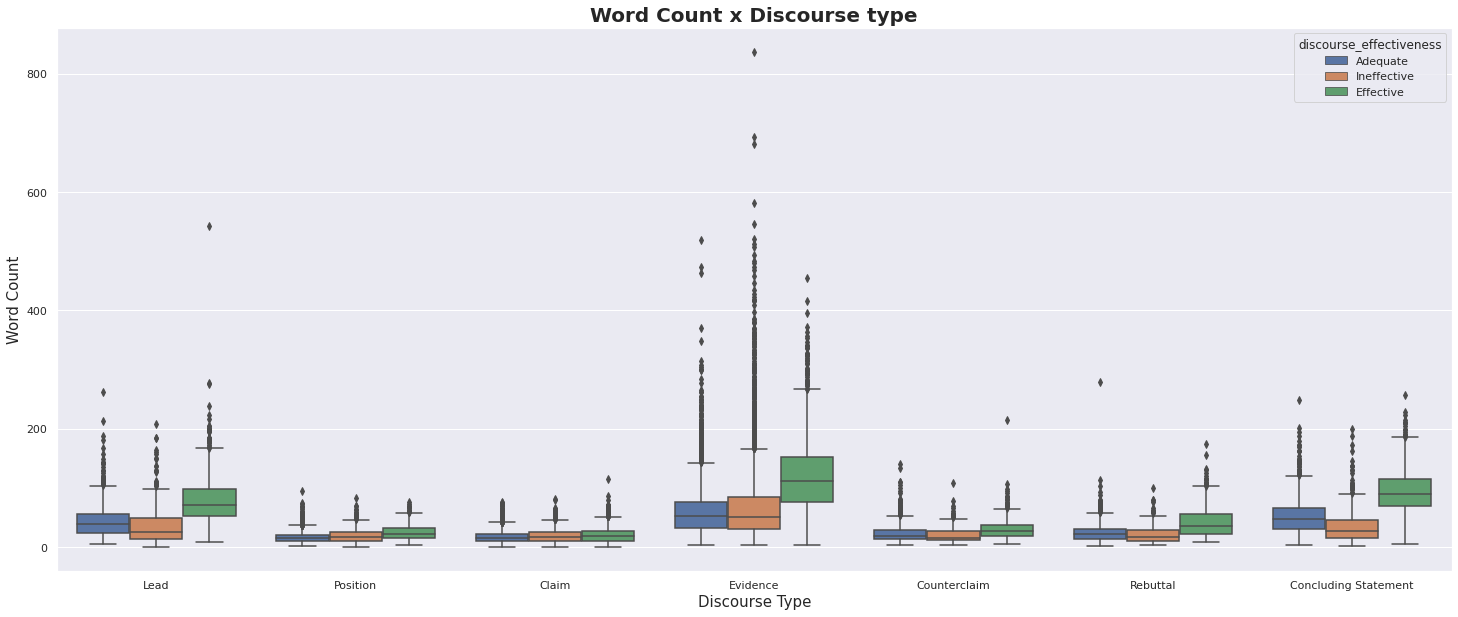

In [18]:
plt.figure(figsize=(25, 10))   
ax = sns.boxplot(x="discourse_type", y="discourse_text_numWords", hue="discourse_effectiveness", data=dataset_train)
#ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Word Count x Discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Word Count", fontsize=15)

**Normalizing and tokenizing data to remove stopwords, lemmatization, removing special characters, etc.**

In [19]:
import sys
sys.path.insert(1, '/kaggle/input/text-preprocessing-and-normalization/')

import text_normalizer as tn
import model_evaluation_utils as meu

Encoding the "discourse_effectiveness" to numbers as it will be our output (prediction class labels):

In [20]:
dataset_train["discourse_effectiveness_encode"] = dataset_train.discourse_effectiveness.replace({"Ineffective": 0, "Adequate":1, "Effective": 2})

Concatenating the "discourse_type" with the "discourse_text" for the training and test set for our input (by concatenating, the algorithm will learn the features of discourse_text presented in each discourse_type).

In [21]:
dataset_train_0 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[0]]
dataset_train_1 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[1]]
dataset_train_2 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[2]]
dataset_train_3 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[3]]
dataset_train_4 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[4]]
dataset_train_5 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[5]]
dataset_train_6 = dataset_train[dataset_train.discourse_type == dataset_train.discourse_type.unique()[6]]

In [22]:
dataset_train_0.shape[0] + dataset_train_1.shape[0] + dataset_train_2.shape[0] + dataset_train_3.shape[0] + dataset_train_4.shape[0] + dataset_train_5.shape[0] + dataset_train_6.shape[0] == dataset_train.shape[0]

True

Passing the dataframes to Numpy arrays:

In [23]:
# Passa para numpy array
train_inputs_0 = np.array(dataset_train_0.discourse_text)
train_inputs_1 = np.array(dataset_train_1.discourse_text)
train_inputs_2 = np.array(dataset_train_2.discourse_text)
train_inputs_3 = np.array(dataset_train_3.discourse_text)
train_inputs_4 = np.array(dataset_train_4.discourse_text)
train_inputs_5 = np.array(dataset_train_5.discourse_text)
train_inputs_6 = np.array(dataset_train_6.discourse_text)

Normalizing the training and test set:

In [24]:
# Normalize datasets
norm_train_inputs_0 = tn.normalize_corpus(train_inputs_0)
norm_train_inputs_1 = tn.normalize_corpus(train_inputs_1)
norm_train_inputs_2 = tn.normalize_corpus(train_inputs_2)
norm_train_inputs_3 = tn.normalize_corpus(train_inputs_3)
norm_train_inputs_4 = tn.normalize_corpus(train_inputs_4)
norm_train_inputs_5 = tn.normalize_corpus(train_inputs_5)
norm_train_inputs_6 = tn.normalize_corpus(train_inputs_6)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Tokenizing the training and test set:

In [25]:
tokenized_train_0 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_0]
tokenized_train_1 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_1]
tokenized_train_2 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_2]
tokenized_train_3 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_3]
tokenized_train_4 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_4]
tokenized_train_5 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_5]
tokenized_train_6 = [tn.tokenizer.tokenize(text) for text in norm_train_inputs_6]

**Building the model**

In [26]:
from collections import Counter

Building vocabulary mapping (word to index):

In [27]:
# Build word to index vocabulary
token_counter_0 = Counter([token for discourse in tokenized_train_0 for token in discourse])
token_counter_1 = Counter([token for discourse in tokenized_train_1 for token in discourse])
token_counter_2 = Counter([token for discourse in tokenized_train_2 for token in discourse])
token_counter_3 = Counter([token for discourse in tokenized_train_3 for token in discourse])
token_counter_4 = Counter([token for discourse in tokenized_train_4 for token in discourse])
token_counter_5 = Counter([token for discourse in tokenized_train_5 for token in discourse])
token_counter_6 = Counter([token for discourse in tokenized_train_6 for token in discourse])

In [28]:
vocab_map_0 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_0).items())}
vocab_map_1 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_1).items())}
vocab_map_2 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_2).items())}
vocab_map_3 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_3).items())}
vocab_map_4 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_4).items())}
vocab_map_5 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_5).items())}
vocab_map_6 = {item[0]: index+1 for index, item in enumerate(dict(token_counter_6).items())}

In [29]:
max_index_0 = np.max(list(vocab_map_0.values()))
max_index_1 = np.max(list(vocab_map_1.values()))
max_index_2 = np.max(list(vocab_map_2.values()))
max_index_3 = np.max(list(vocab_map_3.values()))
max_index_4 = np.max(list(vocab_map_4.values()))
max_index_5 = np.max(list(vocab_map_5.values()))
max_index_6 = np.max(list(vocab_map_6.values()))

In [30]:
vocab_map_0['PAD_INDEX'] = 0
vocab_map_1['PAD_INDEX'] = 0
vocab_map_2['PAD_INDEX'] = 0
vocab_map_3['PAD_INDEX'] = 0
vocab_map_4['PAD_INDEX'] = 0
vocab_map_5['PAD_INDEX'] = 0
vocab_map_6['PAD_INDEX'] = 0

In [31]:
vocab_map_0['NOT_FOUND_INDEX'] = max_index_0+1
vocab_map_1['NOT_FOUND_INDEX'] = max_index_1+1
vocab_map_2['NOT_FOUND_INDEX'] = max_index_2+1
vocab_map_3['NOT_FOUND_INDEX'] = max_index_3+1
vocab_map_4['NOT_FOUND_INDEX'] = max_index_4+1
vocab_map_5['NOT_FOUND_INDEX'] = max_index_5+1
vocab_map_6['NOT_FOUND_INDEX'] = max_index_6+1

In [32]:
vocab_size_0 = len(vocab_map_0)
vocab_size_1 = len(vocab_map_1)
vocab_size_2 = len(vocab_map_2)
vocab_size_3 = len(vocab_map_3)
vocab_size_4 = len(vocab_map_4)
vocab_size_5 = len(vocab_map_5)
vocab_size_6 = len(vocab_map_6)

In [33]:
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size_0)
print('Sample slice of vocabulary map:', dict(list(vocab_map_0.items())[10:20]))

Vocabulary Size: 5423
Sample slice of vocabulary map: {'make': 11, 'story': 12, 'nasa': 13, 'take': 14, 'picture': 15, 'see': 16, 'planet': 17, 'not': 18, 'know': 19, 'create': 20}


Encoding and padding datasets and encoding prediction class labels:

In [34]:
from keras.preprocessing import sequence
#from keras.utils import pad_sequences       # Dependendo da versão do TensorFlow, não precisa rodar essa linha
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Getting max length of train corpus and initializing label encoder

In [35]:
le = LabelEncoder()
num_classes=3 # Ineffective -> 0, Adequate -> 1, Effective -> 2

In [36]:
max_len_0 = np.max([len(discourse) for discourse in tokenized_train_0])
max_len_1 = np.max([len(discourse) for discourse in tokenized_train_1])
max_len_2 = np.max([len(discourse) for discourse in tokenized_train_2])
max_len_3 = np.max([len(discourse) for discourse in tokenized_train_3])
max_len_4 = np.max([len(discourse) for discourse in tokenized_train_4])
max_len_5 = np.max([len(discourse) for discourse in tokenized_train_5])
max_len_6 = np.max([len(discourse) for discourse in tokenized_train_6])

Train discourses data corpus (converting tokenized text discourses to numeric vectors):

In [37]:
## Train discourses data corpus
# Convert tokenized text discourses to numeric vectors
train_X_0 = [[vocab_map_0[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_0]
train_X_1 = [[vocab_map_1[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_1]
train_X_2 = [[vocab_map_2[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_2]
train_X_3 = [[vocab_map_3[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_3]
train_X_4 = [[vocab_map_4[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_4]
train_X_5 = [[vocab_map_5[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_5]
train_X_6 = [[vocab_map_6[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train_6]

In [38]:
train_X_0 = sequence.pad_sequences(train_X_0, maxlen=max_len_0) # pad 
train_X_1 = sequence.pad_sequences(train_X_1, maxlen=max_len_1)
train_X_2 = sequence.pad_sequences(train_X_2, maxlen=max_len_2)
train_X_3 = sequence.pad_sequences(train_X_3, maxlen=max_len_3)
train_X_4 = sequence.pad_sequences(train_X_4, maxlen=max_len_4)
train_X_5 = sequence.pad_sequences(train_X_5, maxlen=max_len_5)
train_X_6 = sequence.pad_sequences(train_X_6, maxlen=max_len_6)

Train prediction class labels (text discourse labels (Ineffective\Adequate\Effective) to encodings (0/1/2) in one hot encoding).

In [39]:
enc = OneHotEncoder()

train_y_0 = np.array(dataset_train_0["discourse_effectiveness_encode"])
train_y_1 = np.array(dataset_train_1["discourse_effectiveness_encode"])
train_y_2 = np.array(dataset_train_2["discourse_effectiveness_encode"])
train_y_3 = np.array(dataset_train_3["discourse_effectiveness_encode"])
train_y_4 = np.array(dataset_train_4["discourse_effectiveness_encode"])
train_y_5 = np.array(dataset_train_5["discourse_effectiveness_encode"])
train_y_6 = np.array(dataset_train_6["discourse_effectiveness_encode"])

train_y_0 = train_y_0.reshape(-1, 1)
train_y_1 = train_y_1.reshape(-1, 1)
train_y_2 = train_y_2.reshape(-1, 1)
train_y_3 = train_y_3.reshape(-1, 1)
train_y_4 = train_y_4.reshape(-1, 1)
train_y_5 = train_y_5.reshape(-1, 1)
train_y_6 = train_y_6.reshape(-1, 1)

train_y_0 = enc.fit_transform(train_y_0).toarray()
train_y_1 = enc.fit_transform(train_y_1).toarray()
train_y_2 = enc.fit_transform(train_y_2).toarray()
train_y_3 = enc.fit_transform(train_y_3).toarray()
train_y_4 = enc.fit_transform(train_y_4).toarray()
train_y_5 = enc.fit_transform(train_y_5).toarray()
train_y_6 = enc.fit_transform(train_y_6).toarray()

Test discourses data corpus (converting tokenized text discourses to numeric vectors) and viewing vector shapes.

In [40]:
# test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
#            for token in tokenized_discourse] 
#               for tokenized_discourse in tokenized_test]
# test_X = sequence.pad_sequences(test_X, maxlen=max_len)

# print('Max length of train discourse vectors:', max_len)
# print('Train discourse vectors shape:', train_X.shape, ' Test discourse vectors shape:', test_X.shape)

Building the LSTM Model Architecture

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [42]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

# Model 0
model_0 = Sequential()
model_0.add(Embedding(input_dim=vocab_size_0, output_dim=EMBEDDING_DIM, input_length=max_len_0))
model_0.add(SpatialDropout1D(0.2))
model_0.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_0.add(Dense(3, activation="softmax"))

model_0.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_0 = ModelCheckpoint(filepath="\\classifier_01-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_0.summary())

2022-07-30 21:53:14.413534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:14.414716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:14.415358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:14.416189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 316, 128)          694144    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 316, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 743,747
Trainable params: 743,747
Non-trainable params: 0
_________________________________________________________________
None


node zero
2022-07-30 21:53:14.417160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:14.417868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:22.193862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:22.194695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 21:53:22.195339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [43]:
earlyStop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        mode='max',
        restore_best_weights=True
)

In [44]:
# Model 1
model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size_1, output_dim=EMBEDDING_DIM, input_length=max_len_1))
model_1.add(SpatialDropout1D(0.2))
model_1.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(3, activation="softmax"))

model_1.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_1 = ModelCheckpoint(filepath="\\classifier_02-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 128)           414592    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 46, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 464,195
Trainable params: 464,195
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# Model 2
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size_2, output_dim=EMBEDDING_DIM, input_length=max_len_2))
model_2.add(SpatialDropout1D(0.2))
model_2.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(3, activation="softmax"))

model_2.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_2 = ModelCheckpoint(filepath="\\classifier_03-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 128)           865664    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 51, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 915,267
Trainable params: 915,267
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# Model 3
model_3 = Sequential()
model_3.add(Embedding(input_dim=vocab_size_3, output_dim=EMBEDDING_DIM, input_length=max_len_3))
model_3.add(SpatialDropout1D(0.2))
model_3.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(3, activation="softmax"))

model_3.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_3 = ModelCheckpoint(filepath="\\classifier_04-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 395, 128)          2267904   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 395, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 2,317,507
Trainable params: 2,317,507
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
# Model 4
model_4 = Sequential()
model_4.add(Embedding(input_dim=vocab_size_4, output_dim=EMBEDDING_DIM, input_length=max_len_4))
model_4.add(SpatialDropout1D(0.2))
model_4.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_4.add(Dense(3, activation="softmax"))

model_4.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_4 = ModelCheckpoint(filepath="\\classifier_05-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 110, 128)          355456    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 110, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 405,059
Trainable params: 405,059
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
# Model 5
model_5 = Sequential()
model_5.add(Embedding(input_dim=vocab_size_5, output_dim=EMBEDDING_DIM, input_length=max_len_5))
model_5.add(SpatialDropout1D(0.2))
model_5.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_5.add(Dense(3, activation="softmax"))

model_5.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_5 = ModelCheckpoint(filepath="\\classifier_06-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 145, 128)          347776    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 145, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 397,379
Trainable params: 397,379
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# Model 6
model_6 = Sequential()
model_6.add(Embedding(input_dim=vocab_size_6, output_dim=EMBEDDING_DIM, input_length=max_len_6))
model_6.add(SpatialDropout1D(0.2))
model_6.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model_6.add(Dense(3, activation="softmax"))

model_6.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath=data_path + "\\classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer_6 = ModelCheckpoint(filepath="\\classifier_07-{epoch:02d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

print(model_6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 125, 128)          832000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 125, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 881,603
Trainable params: 881,603
Non-trainable params: 0
_________________________________________________________________
None


Visualizing model architecture

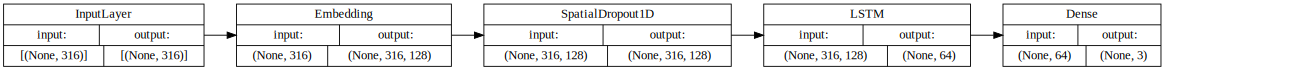

In [50]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_0, show_shapes=True, show_layer_names=False, 
                 rankdir='LR', dpi=65).create(prog='dot', format='svg'))

Training the model

In [51]:
batch_size = 100
#model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
model_0.fit(train_X_0, train_y_0, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_0, earlyStop], verbose=1)

2022-07-30 21:53:25.438136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
21/21 [==============================] - 32s 1s/step - loss: 0.9961 - accuracy: 0.5497 - val_loss: 0.9416 - val_accuracy: 0.5696

Epoch 00001: val_accuracy improved from -inf to 0.56957, saving model to \classifier_01-01-0.5696.hdf5
Epoch 2/20
21/21 [==============================] - 29s 1s/step - loss: 0.8237 - accuracy: 0.6526 - val_loss: 0.7961 - val_accuracy: 0.6522

Epoch 00002: val_accuracy improved from 0.56957 to 0.65217, saving model to \classifier_01-02-0.6522.hdf5
Epoch 3/20
21/21 [==============================] - 28s 1s/step - loss: 0.7312 - accuracy: 0.6812 - val_loss: 0.7667 - val_accuracy: 0.6565

Epoch 00003: val_accuracy improved from 0.65217 to 0.65652, saving model to \classifier_01-03-0.6565.hdf5
Epoch 4/20
21/21 [==============================] - 28s 1s/step - loss: 0.6031 - accuracy: 0.7390 - val_loss: 0.7487 - val_accuracy: 0.6696

Epoch 00004: val_accuracy improved from 0.65652 to 0.66957, saving model to \classifier_01-04-0.6696.hdf5
Epoch 5/20
21/2

In [52]:
model_1.fit(train_X_1, train_y_1, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_1, earlyStop], verbose=1)

Epoch 1/20
37/37 [==============================] - 10s 202ms/step - loss: 0.8446 - accuracy: 0.6990 - val_loss: 0.9386 - val_accuracy: 0.5682

Epoch 00001: val_accuracy improved from -inf to 0.56824, saving model to \classifier_02-01-0.5682.hdf5
Epoch 2/20
37/37 [==============================] - 7s 197ms/step - loss: 0.7323 - accuracy: 0.7167 - val_loss: 0.8698 - val_accuracy: 0.6328

Epoch 00002: val_accuracy improved from 0.56824 to 0.63275, saving model to \classifier_02-02-0.6328.hdf5
Epoch 3/20
37/37 [==============================] - 8s 225ms/step - loss: 0.6523 - accuracy: 0.7454 - val_loss: 0.8725 - val_accuracy: 0.6377

Epoch 00003: val_accuracy improved from 0.63275 to 0.63772, saving model to \classifier_02-03-0.6377.hdf5
Epoch 4/20
37/37 [==============================] - 8s 207ms/step - loss: 0.5634 - accuracy: 0.7788 - val_loss: 0.8960 - val_accuracy: 0.6501

Epoch 00004: val_accuracy improved from 0.63772 to 0.65012, saving model to \classifier_02-04-0.6501.hdf5
Epoch 

In [53]:
model_2.fit(train_X_2, train_y_2, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_2, earlyStop], verbose=1)

Epoch 1/20
108/108 [==============================] - 28s 238ms/step - loss: 0.8968 - accuracy: 0.6168 - val_loss: 0.9157 - val_accuracy: 0.5326

Epoch 00001: val_accuracy improved from -inf to 0.53255, saving model to \classifier_03-01-0.5326.hdf5
Epoch 2/20
108/108 [==============================] - 25s 231ms/step - loss: 0.7528 - accuracy: 0.6793 - val_loss: 0.8975 - val_accuracy: 0.5718

Epoch 00002: val_accuracy improved from 0.53255 to 0.57179, saving model to \classifier_03-02-0.5718.hdf5
Epoch 3/20
108/108 [==============================] - 25s 229ms/step - loss: 0.6595 - accuracy: 0.7147 - val_loss: 0.9411 - val_accuracy: 0.5668

Epoch 00003: val_accuracy did not improve from 0.57179
Epoch 4/20
108/108 [==============================] - 24s 222ms/step - loss: 0.5842 - accuracy: 0.7552 - val_loss: 0.9667 - val_accuracy: 0.5676

Epoch 00004: val_accuracy did not improve from 0.57179
Epoch 5/20
108/108 [==============================] - 25s 234ms/step - loss: 0.5210 - accuracy: 0

In [54]:
model_3.fit(train_X_3, train_y_3, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_3, earlyStop], verbose=1)

Epoch 1/20
109/109 [==============================] - 184s 2s/step - loss: 0.9125 - accuracy: 0.5593 - val_loss: 0.8103 - val_accuracy: 0.6515

Epoch 00001: val_accuracy improved from -inf to 0.65153, saving model to \classifier_04-01-0.6515.hdf5
Epoch 2/20
109/109 [==============================] - 182s 2s/step - loss: 0.7510 - accuracy: 0.6442 - val_loss: 0.8422 - val_accuracy: 0.6557

Epoch 00002: val_accuracy improved from 0.65153 to 0.65566, saving model to \classifier_04-02-0.6557.hdf5
Epoch 3/20
109/109 [==============================] - 182s 2s/step - loss: 0.6385 - accuracy: 0.7220 - val_loss: 0.9479 - val_accuracy: 0.5838

Epoch 00003: val_accuracy did not improve from 0.65566
Epoch 4/20
109/109 [==============================] - 184s 2s/step - loss: 0.5241 - accuracy: 0.7834 - val_loss: 0.9831 - val_accuracy: 0.6325

Epoch 00004: val_accuracy did not improve from 0.65566
Epoch 5/20
109/109 [==============================] - 185s 2s/step - loss: 0.4322 - accuracy: 0.8274 - va

In [55]:
model_4.fit(train_X_4, train_y_4, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_4, earlyStop], verbose=1)

Epoch 1/20
16/16 [==============================] - 10s 469ms/step - loss: 0.9730 - accuracy: 0.6257 - val_loss: 0.7854 - val_accuracy: 0.6742

Epoch 00001: val_accuracy improved from -inf to 0.67416, saving model to \classifier_05-01-0.6742.hdf5
Epoch 2/20
16/16 [==============================] - 7s 462ms/step - loss: 0.8703 - accuracy: 0.6458 - val_loss: 0.7870 - val_accuracy: 0.6742

Epoch 00002: val_accuracy did not improve from 0.67416
Epoch 3/20
16/16 [==============================] - 8s 525ms/step - loss: 0.8315 - accuracy: 0.6458 - val_loss: 0.7806 - val_accuracy: 0.6742

Epoch 00003: val_accuracy did not improve from 0.67416
Epoch 4/20
16/16 [==============================] - 8s 490ms/step - loss: 0.7657 - accuracy: 0.6639 - val_loss: 0.7494 - val_accuracy: 0.6854

Epoch 00004: val_accuracy improved from 0.67416 to 0.68539, saving model to \classifier_05-04-0.6854.hdf5
Epoch 5/20
16/16 [==============================] - 7s 454ms/step - loss: 0.6569 - accuracy: 0.7266 - val_lo

In [56]:
model_5.fit(train_X_5, train_y_5, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_5, earlyStop], verbose=1)

Epoch 1/20
12/12 [==============================] - 9s 609ms/step - loss: 1.0516 - accuracy: 0.5139 - val_loss: 0.9379 - val_accuracy: 0.5680

Epoch 00001: val_accuracy improved from -inf to 0.56800, saving model to \classifier_06-01-0.5680.hdf5
Epoch 2/20
12/12 [==============================] - 8s 651ms/step - loss: 0.9560 - accuracy: 0.5559 - val_loss: 0.8943 - val_accuracy: 0.5680

Epoch 00002: val_accuracy did not improve from 0.56800
Epoch 3/20
12/12 [==============================] - 7s 623ms/step - loss: 0.9152 - accuracy: 0.5827 - val_loss: 0.8537 - val_accuracy: 0.6320

Epoch 00003: val_accuracy improved from 0.56800 to 0.63200, saving model to \classifier_06-03-0.6320.hdf5
Epoch 4/20
12/12 [==============================] - 8s 641ms/step - loss: 0.8447 - accuracy: 0.6425 - val_loss: 0.7561 - val_accuracy: 0.6960

Epoch 00004: val_accuracy improved from 0.63200 to 0.69600, saving model to \classifier_06-04-0.6960.hdf5
Epoch 5/20
12/12 [==============================] - 7s 591

In [57]:
model_6.fit(train_X_6, train_y_6, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer_6, earlyStop], verbose=1)

Epoch 1/20
31/31 [==============================] - 19s 547ms/step - loss: 0.9130 - accuracy: 0.6053 - val_loss: 0.7663 - val_accuracy: 0.6339

Epoch 00001: val_accuracy improved from -inf to 0.63393, saving model to \classifier_07-01-0.6339.hdf5
Epoch 2/20
31/31 [==============================] - 17s 561ms/step - loss: 0.7113 - accuracy: 0.6816 - val_loss: 0.8419 - val_accuracy: 0.6488

Epoch 00002: val_accuracy improved from 0.63393 to 0.64881, saving model to \classifier_07-02-0.6488.hdf5
Epoch 3/20
31/31 [==============================] - 17s 534ms/step - loss: 0.6019 - accuracy: 0.7297 - val_loss: 0.9029 - val_accuracy: 0.6429

Epoch 00003: val_accuracy did not improve from 0.64881
Epoch 4/20
31/31 [==============================] - 17s 567ms/step - loss: 0.4949 - accuracy: 0.7864 - val_loss: 0.8097 - val_accuracy: 0.6548

Epoch 00004: val_accuracy improved from 0.64881 to 0.65476, saving model to \classifier_07-04-0.6548.hdf5
Epoch 5/20
31/31 [==============================] - 16

**Submitting the model**

In [58]:
submission_file = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/sample_submission.csv")

submission_file

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47
5,2e214524dbe3,0.20,0.60,0.40
6,84812fc2ab9f,3.00,6.00,1.00
7,c668ff840720,1.00,2.00,3.00
8,739a6d00f44a,0.33,0.34,0.33
9,bcfae2c9a244,0.01,0.24,0.47


In [59]:
# Predict and Evaluate Model Performance
for rtx in range(len(dataset_test)):
    # Passa para numpy array
    #test_inputs = np.array(dataset_test["discourse_text"][rtx])
    test_inputs = np.empty(shape=(1,), dtype=object)
    test_inputs[0] = dataset_test["discourse_text"][rtx]
    
    # Normalize datasets
    norm_test_inputs = tn.normalize_corpus(test_inputs)

    # Tokenize train & test datasets
    tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_inputs]
    
    if dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[0]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_0[token] if vocab_map_0.get(token) else vocab_map_0['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_0)
        #test_X = pad_sequences(test_X, maxlen=max_len_0)
        
        # Predict and Evaluate Model Performance
        #pred_test = model_0.predict_classes(test_X)
        test_y = model_0.predict(test_X, verbose=1)
        
    elif dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[1]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_1[token] if vocab_map_1.get(token) else vocab_map_1['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_1)
        #test_X = pad_sequences(test_X, maxlen=max_len_1)
        
        # Predict and Evaluate Model Performance
        #pred_test = model_1.predict_classes(test_X)
        test_y = model_1.predict(test_X, verbose=1)
        
    elif dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[2]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_2[token] if vocab_map_2.get(token) else vocab_map_2['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_2)
        #test_X = pad_sequences(test_X, maxlen=max_len_2)
        
        # Predict and Evaluate Model Performance
        #pred_test = model.predict_classes(test_X)
        test_y = model_2.predict(test_X, verbose=1)
        
    elif dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[3]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_3[token] if vocab_map_3.get(token) else vocab_map_3['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_3)
        #test_X = pad_sequences(test_X, maxlen=max_len_3)
        
        # Predict and Evaluate Model Performance
        #pred_test = model.predict_classes(test_X)
        test_y = model_3.predict(test_X, verbose=1)
        
    elif dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[4]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_4[token] if vocab_map_4.get(token) else vocab_map_4['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_4)
        #test_X = pad_sequences(test_X, maxlen=max_len_4)
        
        # Predict and Evaluate Model Performance
        #pred_test = model.predict_classes(test_X)
        test_y = model_4.predict(test_X, verbose=1)
        
    elif dataset_test.discourse_type[rtx] == dataset_train.discourse_type.unique()[5]:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_5[token] if vocab_map_5.get(token) else vocab_map_5['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_5)
        #test_X = pad_sequences(test_X, maxlen=max_len_5)
        
        # Predict and Evaluate Model Performance
        #pred_test = model.predict_classes(test_X)
        test_y = model_5.predict(test_X, verbose=1)
        
    else:
        ## Test discourses data corpus
        # Convert tokenized text discourses to numeric vectors
        test_X = [[vocab_map_6[token] if vocab_map_6.get(token) else vocab_map_6['NOT_FOUND_INDEX'] 
                   for token in tokenized_discourse] 
                      for tokenized_discourse in tokenized_test]
        test_X = sequence.pad_sequences(test_X, maxlen=max_len_6)
        #test_X = pad_sequences(test_X, maxlen=max_len_6)
        
        # Predict and Evaluate Model Performance
        #pred_test = model.predict_classes(test_X)
        test_y = model_6.predict(test_X, verbose=1)
        
    submission_file["Ineffective"][rtx] = test_y[0, 0]
    submission_file["Adequate"][rtx] = test_y[0, 1]
    submission_file["Effective"][rtx] = test_y[0, 2]

1/1 [==============================] - 0s 299ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 216ms/step


In [60]:
# Predictions
#test_y = model.predict(test_X, verbose=1)
#test_y

Loading submission template to paste the predictions to and then saving the file:

In [61]:
#submission_file = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/sample_submission.csv")

submission_file

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.002299,0.014599,0.983102
1,5a88900e7dc1,0.150915,0.719789,0.129296
2,9790d835736b,0.042501,0.424913,0.532586
3,75ce6d68b67b,0.069652,0.486056,0.444292
4,93578d946723,0.095274,0.487629,0.417098
5,2e214524dbe3,0.097100,0.335804,0.567096
6,84812fc2ab9f,0.060311,0.595423,0.344266
7,c668ff840720,0.063674,0.409164,0.527162
8,739a6d00f44a,0.187631,0.590310,0.222059
9,bcfae2c9a244,0.050719,0.687254,0.262027


In [62]:
#submission_file["Ineffective"] = test_y[:, 0]
#submission_file["Adequate"] = test_y[:, 1]
#submission_file["Effective"] = test_y[:, 2]

#submission_file

In [63]:
submission_file.to_csv("submission.csv", index=False)